In [1]:
# Install PyTorch without GPU support
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!pip install entmax


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: https://download.pytorch.org/whl/cpu
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or L

# Hopfield Networks

In this notebook, we provide a walkthorugh for implementing sparse and structured Hopfield networks.

## Sparse Hopfield-like Energy Functions

In this section, we assume that the regularizer $\Omega$ has domain $\mathrm{dom}(\Omega) = \triangle_N$ and that it is a **generalized negentropy** or that $\Omega$ has domain in the polytope $\mathrm{conv}(Y)$ for the $k$-subsets case.

[(Santos et al., 2024)](https://openreview.net/pdf/565c1f8b00f4fdecff6e2b1eddfc418f06f64e4d.pdf) used the definition that $\Omega'(\mathbf{\theta}) = \Omega(\beta \mathbf{\theta})$, obtaining the following energy, up to an extra constant:

$$
E(\mathbf{q}) = \underbrace{-\beta^{-1} L_\Omega(\beta \mathbf{X} \mathbf{q}; \mathbf{1}/{N})}_{E_{\mathrm{concave}}(\mathbf{q})} + \underbrace{\frac{1}{2} \|\mathbf{q} - \mathbf{\mu}_{\mathbf{X}}\|^2 + \frac{1}{2}(M^2 - \|\mathbf{\mu}_{\mathbf{X}}\|^2)}_{{E_{\mathrm{convex}}(\mathbf{q})}}
$$

where $\mathbf{\mu}_{\mathbf{X}} := \mathbf{X}^\top \mathbf{1}/N \in \mathbb{R}^D$ is the empirical mean of the patterns, and $M := \max_i \|\mathbf{x}_i\|$. 

This energy extends that of the standard Hopfield model, which is recovered when $\Omega$ is Shannon's negentropy.

The $E_{\text{convex}}$ and $E_{\text{concave}}$ terms compete when minimizing the energy:

- Minimizing $E_{\mathrm{concave}}$ is equivalent to *maximizing* $L_{\Omega}(\beta \mathbf{X} \mathbf{q}; \mathbf{1}/{N})$, which pushes $\mathbf{q}$ to be as far as possible from a uniform average and closer to a single pattern.
- Minimizing $E_{\mathrm{convex}}$ serves as a proximity regularization, encouraging the state pattern $\mathbf{q}$ to stay close to $\mathbf{\mu}_{\mathbf{X}}$.

## Update Rule of Sparse HFY Energies

Furthermore, minimizing the energy with the CCCP algorithm leads to the updates:

$$\mathbf{q}^{(t+1)} = \mathbf{X}^\top \hat{\mathbf{y}}_\Omega(\beta \mathbf{X} \mathbf{q}^{(t)})$$

This result generalizes previous work on modern Hopfield networks.

## MNIST Retrieval
In this section, we demonstrate the retrieval behavior of our sparse and structured Hopfield networks by storing MNIST digit images in memory and evaluating the performance of this various Hopfield network variants on this memory.

### Wrap Up

In [2]:
import torch
from torchvision import datasets, transforms

# Set manual seed
torch.random.manual_seed(41)

# Class to flatten images
class Flatten(object):

    def __call__(self, tensor):
        return torch.flatten(tensor)

    def __repr__(self):
        return self.__class__.__name__ + '()'

# Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
    Flatten()  
])

# Download dataset
mnist_dataset = datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=len(mnist_dataset), shuffle=True)

for data in data_loader:
    X_train, labels_train = data

### Memory

Here, we create a memory of 20 MNIST images and plot them.

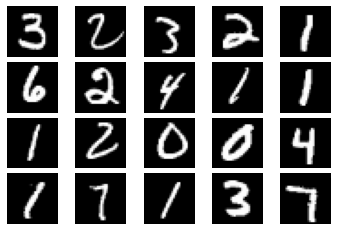

In [3]:
from matplotlib import pyplot as plt
# Define the memory size
memory_size = 20
memory = X_train[:memory_size].view(-1, 28, 28)

# Plot the memory
fig, axes = plt.subplots(4, 5, figsize=(6, 4))

axes = axes.flatten()

for i in range(memory_size):
    axes[i].imshow(memory[i].numpy(), cmap='gray')
    axes[i].axis('off') 

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### Half Masking

**In this experiment**, we select an index corresponding to a memory element and apply a *bottom-half mask* to demonstrate the retrieval behavior of the query. We choose the digit 2, as it appears four times in the memory, making it an interesting case for retrieval.




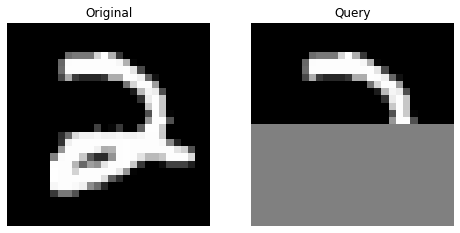

In [4]:
X_stored = memory.view(20, 784)
rows, cols = 28, 28

# Select memory index
index = 3

# Calculate the number of rows to set to 0 intensity
rows_to_whiten = int(0.5 * rows)
X_to_retrieve = X_stored[index].view(28,28)

# Plot both images side by side
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# Plot the original image
ax[0].imshow(X_to_retrieve, cmap='gray', vmin=-1, vmax=1)
ax[0].axis('off')  # Hide axis labels and ticks
ax[0].set_title("Original")

# Apply the whitening mask (set bottom 50% of rows to zero)
X_test_whitened = X_to_retrieve.clone()  
X_test_whitened[-rows_to_whiten:] = 0

# Plot the masked image
ax[1].imshow(X_test_whitened, cmap='gray', vmin=-1, vmax=1)
ax[1].axis('off')  # Hide axis labels and ticks
ax[1].set_title("Query")

# Display the images
plt.show()


### Hopfield Net

Here, we create our Hopfield network class flexible for the sparse and structured transformations.

In [5]:
from entmax import budget_bisect, normmax_bisect, entmax_bisect

class HopfieldNet(torch.nn.Module):
    def __init__(self, 
                 in_features,
                 alpha=1.0,
                 beta=1.0,
                 max_iter=128,
                 sparsemap = False,
                 normmax = False,
                 factor = "budget",
                 k = 2
                ):
        
        super(HopfieldNet, self).__init__()
        self.sparsemap = sparsemap
        self.normmax = normmax
        self.X = in_features
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.k = k


    def _energy(self, Q):
        return energy(Q, self.X, self.alpha, self.beta)
        
    def _run(self, Q, eps=1e-6):

        for _ in range(self.max_iter):
            if self.sparsemap:
                p = budget_bisect(self.beta * self.X.mm(Q), self.k, dim=0)
            elif self.normmax:
                p = normmax_bisect(self.beta * self.X.mm(Q), alpha=self.alpha, n_iter=100, dim=0)
            else:
                p = entmax_bisect(self.beta * self.X.mm(Q), self.alpha, dim=0)
                if self.alpha == 1:
                    p = torch.softmax(self.beta * self.X.mm(Q), dim=0) 
            Q = self.X.T @ p
        
        return Q, p

    def forward(self, Q):
        return self._run(Q)

### Memories Triggered

Here, we show the memories activated by three different Hopfield networks, 1.5-entmax, 2-normmax and 3-subsets.

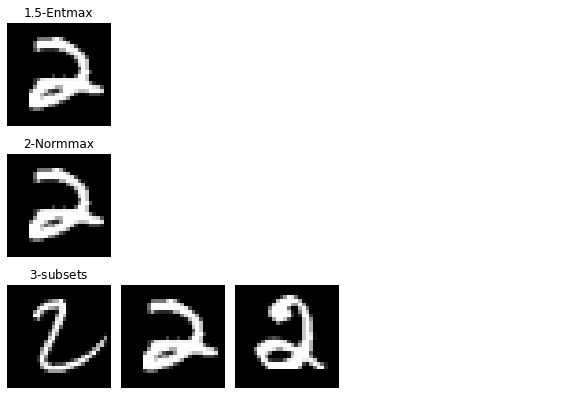

In [6]:
# Define beta values
beta = 10

# Define activation function names
activation_functions = ["1.5-Entmax","2-Normmax", "$3$-subsets"]

# Create a figure with rows for beta values and columns for activation functions
num_rows = len(activation_functions)
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7))

for row_axes in axes:
    for ax in row_axes:
        ax.axis('off')
Qs = []

# Choose the desired parameters here
for j, activation in enumerate(activation_functions):
    if activation == "2-Normmax":
        model = HopfieldNet(in_features=X_stored, alpha=2.0, beta=beta, max_iter=5)
    
    elif activation == "1.5-Entmax":
        model = HopfieldNet(in_features=X_stored, alpha=1.5, beta=beta, max_iter=5)
    
    elif activation == "$3$-subsets":
        model = HopfieldNet(in_features=X_stored, alpha=1.0, beta=beta, max_iter=100, sparsemap=True, k=3)
    
    Q, p = model(X_test_whitened.flatten().view(784, 1))
    Qs.append(Q)
    
    eps_ = 1e-2 if activation == "Softmax" else 0
    surpass_indices = torch.where(p > eps_)[0]
    axes[j, 0].set_title(f"{activation}")
    for i, idx in enumerate(surpass_indices):
        ax = axes[j, i]
        ax.imshow(X_stored[idx].view(28, 28), cmap='gray')
        ax.axis('off')  
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

As expected 1.5-entmax and 2-normmax due to their sparse nature will retrieve the closest memory pattern to the query while 3-subsets will retrivel the 3 closest memory patterns.

### Retrieved Patterns
Here, we show not the activated memories but the fully retrieved patterns.

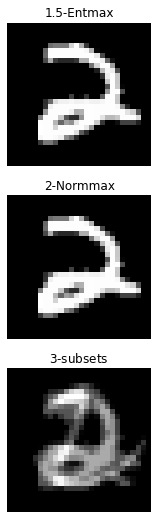

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(3, 9)) 
axes = axes.flatten()

for i in range(len(activation_functions)): 
    axes[i].imshow(Qs[i].view(28, 28).numpy(), cmap='gray') 
    axes[i].axis('off')  
    axes[i].set_title(activation_functions[i])

plt.show()

## Influence Of $\beta$ In Sparse Hopfield Networks

In this experiment we show the sensitivity of the sparse Hopfield networks with $\beta$.

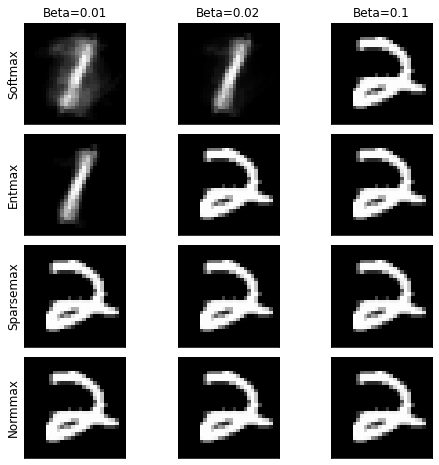

In [8]:
# Define the beta values
betas = [0.01, 0.02, 0.1]
model_types = ['softmax', 'entmax', 'sparsemax', 'normmax']

Qs = []
for model_type in model_types:
    for beta in betas:
        # Instantiate the model with appropriate parameters
        if model_type == 'softmax':
            model = HopfieldNet(in_features=X_stored, alpha=1, beta=beta, max_iter=5)
        elif model_type == 'entmax':
            model = HopfieldNet(in_features=X_stored, alpha=1.5, beta=beta, max_iter=5)
        elif model_type == 'sparsemax':
            model = HopfieldNet(in_features=X_stored, alpha=2, beta=beta, max_iter=5)
        elif model_type == 'normmax':
            model = HopfieldNet(in_features=X_stored, alpha=2, beta=beta, max_iter=5, normmax=True)
        
        Q,p = model(X_test_whitened.flatten().view(784, 1))
        Qs.append(Q)

fig, axes = plt.subplots(len(model_types), len(betas), figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(Qs[i].view(28, 28).numpy(), cmap="gray")  
    ax.set_title
    ax.set_xticks([])
    ax.set_yticks([])

for row, model_type in enumerate(model_types):
    axes[row, 0].set_ylabel(model_type.capitalize(), fontsize=12)

for col, beta in enumerate(betas):
    axes[0, col].set_title(f"Beta={beta}", fontsize=12)
plt.subplots_adjust(wspace=0.1, hspace=0.1)## Influence Of $\beta$ In Sparse Hopfield Networks
plt.show()

As expected, the sparsity of the method influences the sensitivity of the Hopfield network to $\beta$, with sparser methods exhibiting reduced sensitivity.